In [81]:
%reload_ext autoreload
%autoreload 2

#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os
repo_path = os.path.abspath("../")

import sys
sys.path.insert(0, repo_path)

from model_functions_initial.utility import utility_functions
from model_functions_initial.final_period_utility import final_period_utility
from model_functions_initial.budget import budget_dcegm_initial
from model_functions_initial.state_space_functions import create_state_space_function_dict
from model_functions_initial.compute_moments import compute_simulation_moments
from model_functions_initial.compute_moments import compute_simulation_moments_with_ci
from plots.plots import plot_empirical_vs_simulated_with_ci
from model_functions_initial.estimation import estimate_msm
from first_step.load_params import load_params_txt
from model_functions_counter.compute_counterfac import compute_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_cf_diff_separate
from model_functions_counter.compute_counterfac import compute_diff_by_edu
from model_functions_counter.compute_counterfac import plot_metrics_individual
from model_functions_counter.compute_counterfac import plot_separate_metric_panels

from model_functions_counter.budget_counter import budget_dcegm_counter_oap

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = repo_path + "/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash 47f27e8 #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

In [82]:
BASE = repo_path + "/oap_counterfactuals/expected"
edus = ["edu1","edu2","edu3"]

# 1) Load into dictionaries
moments = {}
for edu in edus:
    moments[edu] = {}
    init_path = os.path.join(BASE, f"moments_init_{edu}.pkl")
    cf_path   = os.path.join(BASE, f"moments_cf_{edu}.pkl")
    
    if os.path.exists(init_path):
        moments[edu]["init"] = pd.read_pickle(init_path)
    else:
        print(f"Warning: File not found: {init_path}")
        moments[edu]["init"] = pd.DataFrame()  # Initialize with an empty DataFrame
    
    if os.path.exists(cf_path):
        moments[edu]["cf"] = pd.read_pickle(cf_path)
    else:
        print(f"Warning: File not found: {cf_path}")
        moments[edu]["cf"] = pd.DataFrame()  # Initialize with an empty DataFrame

# 2) Tag & concat into one DataFrame per scenario
df_init = pd.concat(
    [moments[edu]["init"].assign(edu=edu) for edu in edus],
    ignore_index=True
)
df_cf   = pd.concat(
    [moments[edu]["cf"].assign(edu=edu)   for edu in edus],
    ignore_index=True
)


In [83]:
metrics = ["avg_hours", "avg_wealth", "avg_consumption", "prob_work"]
df_diff_all = compute_diff_by_edu(df_init, df_cf, metrics)

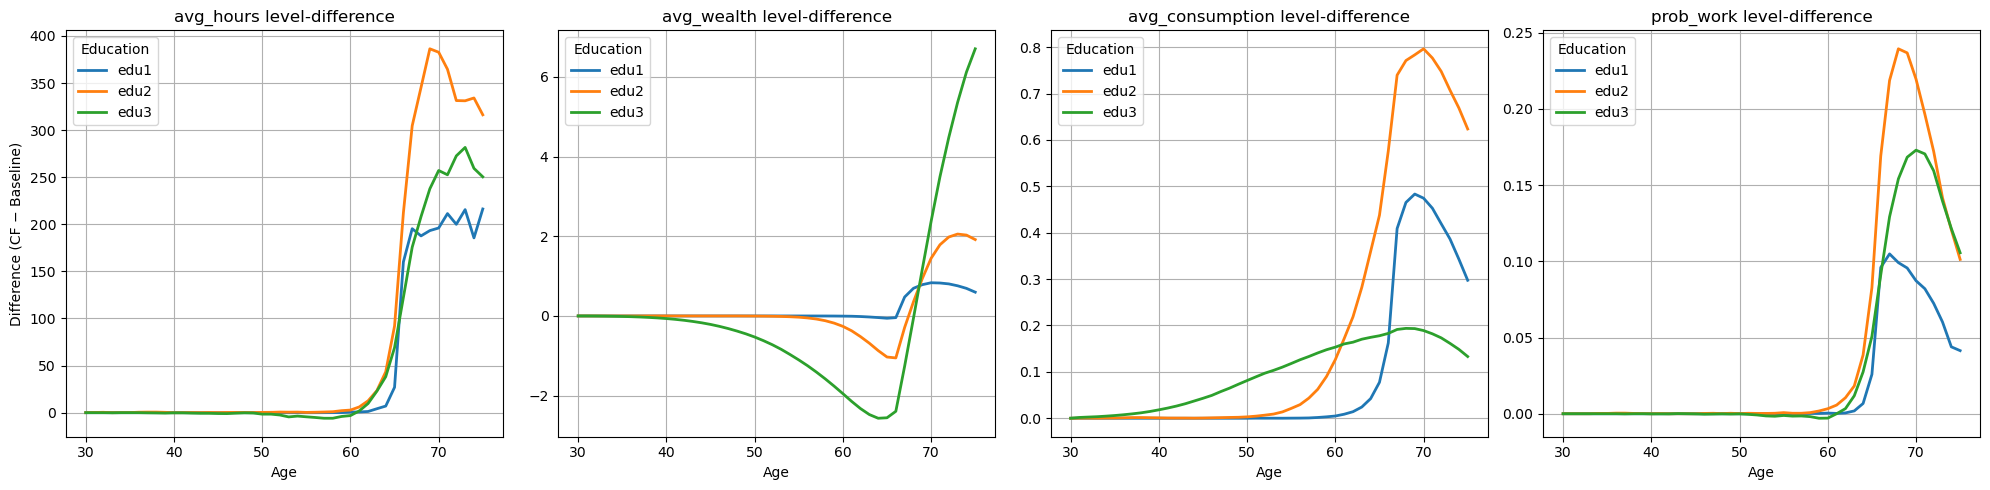

In [84]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_diff"], lw=2, label=edu)
    ax.set_title(f"{m} level‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Difference (CF − Baseline)")
plt.tight_layout()
plt.show()

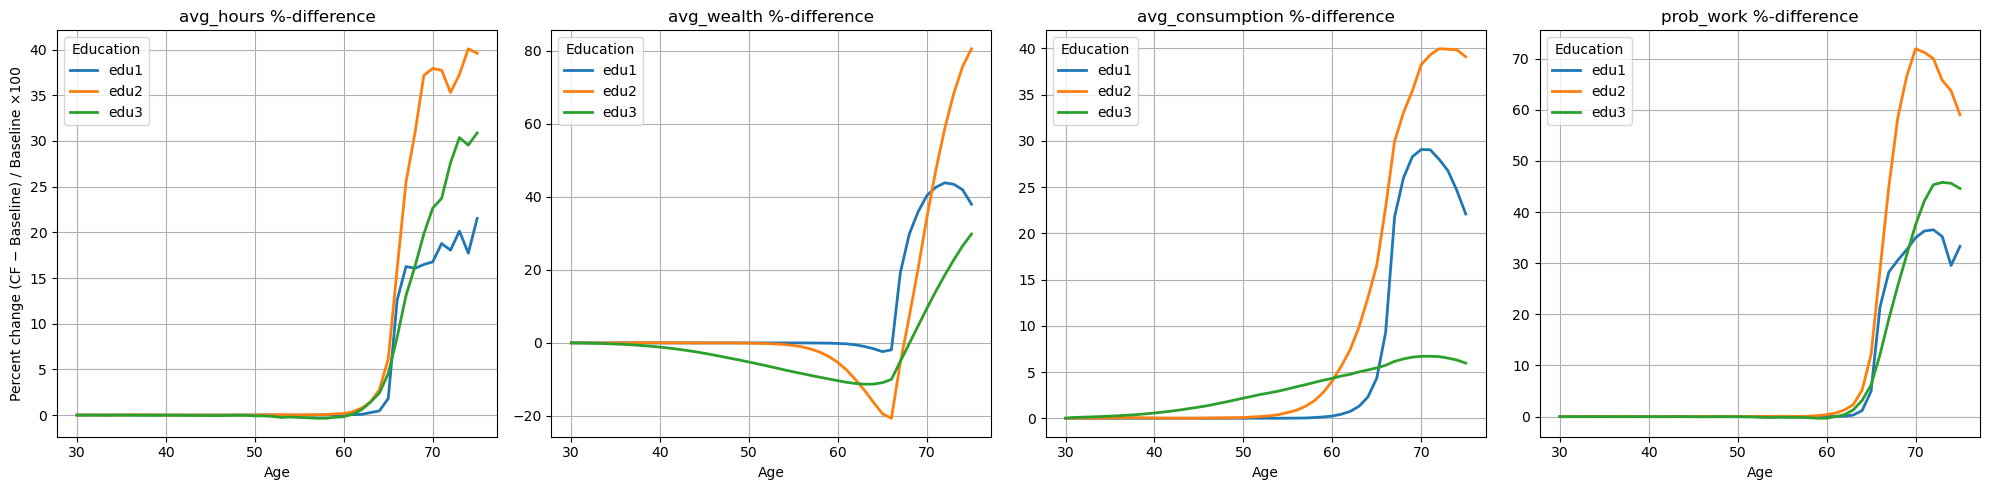

In [85]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_pct"], lw=2, label=edu)
    ax.set_title(f"{m} %‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Percent change (CF − Baseline) / Baseline ×100")
plt.tight_layout()
plt.show()

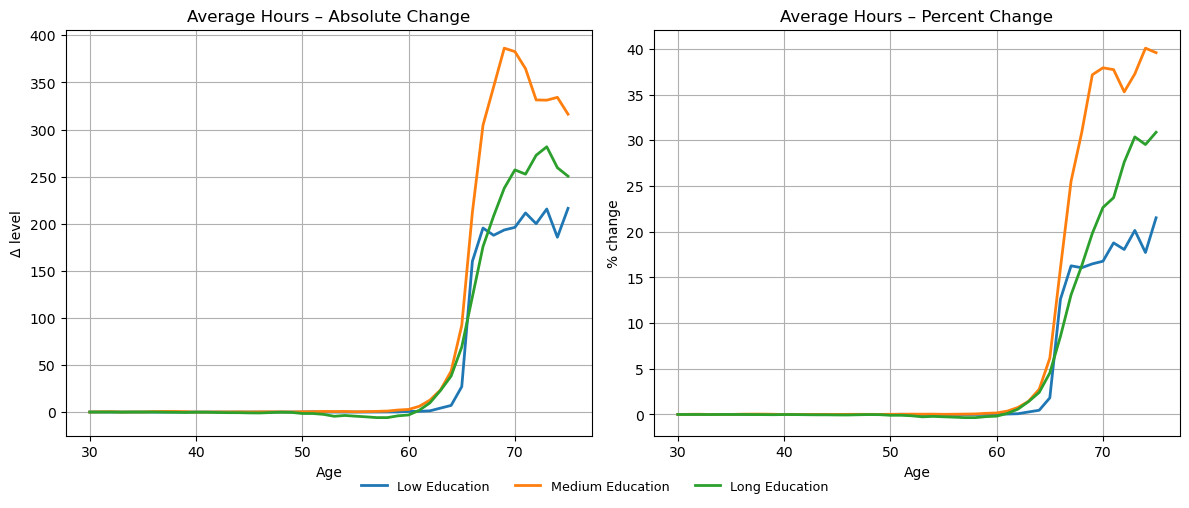

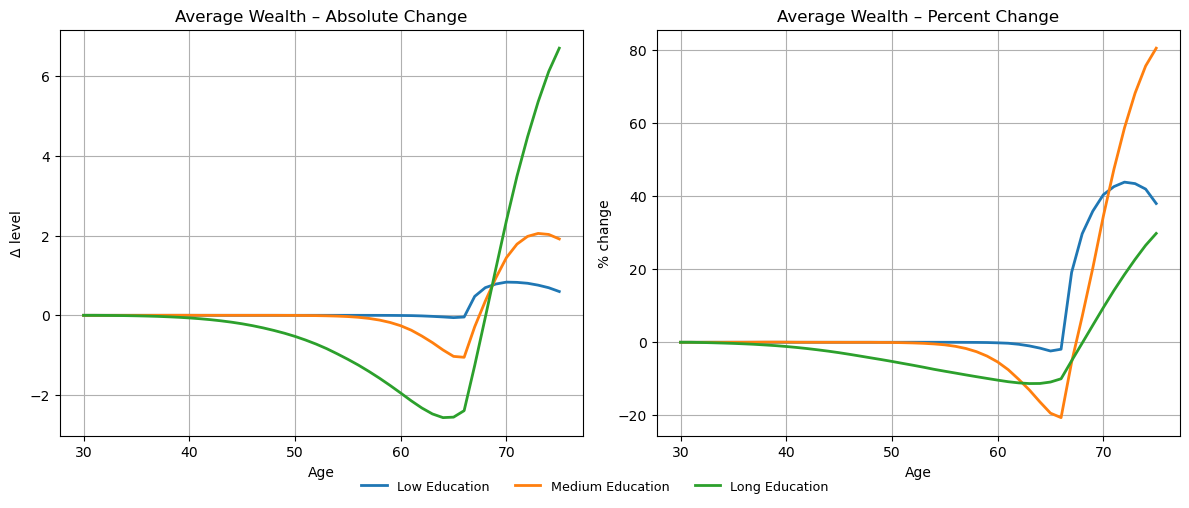

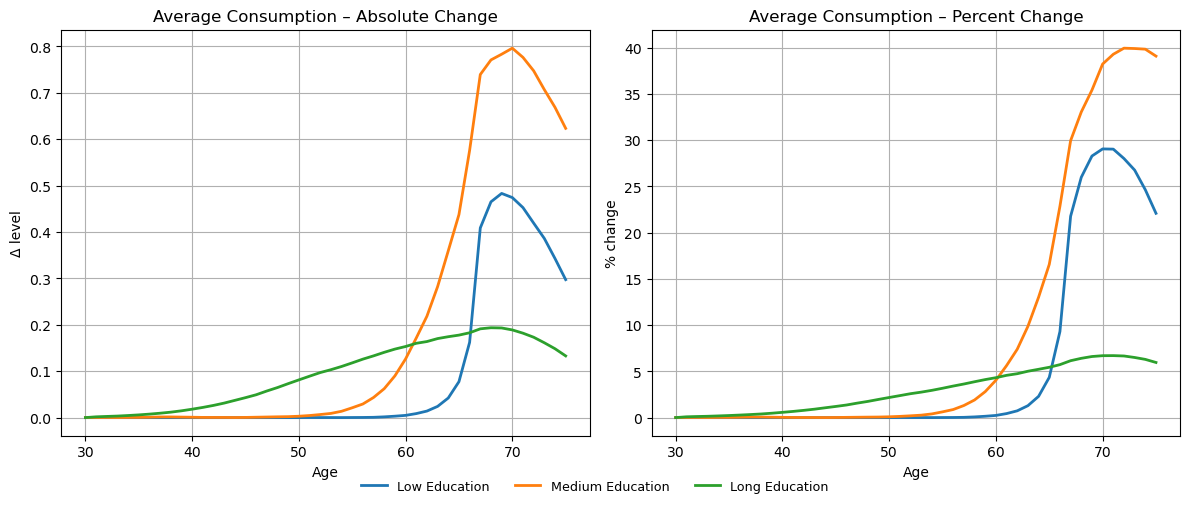

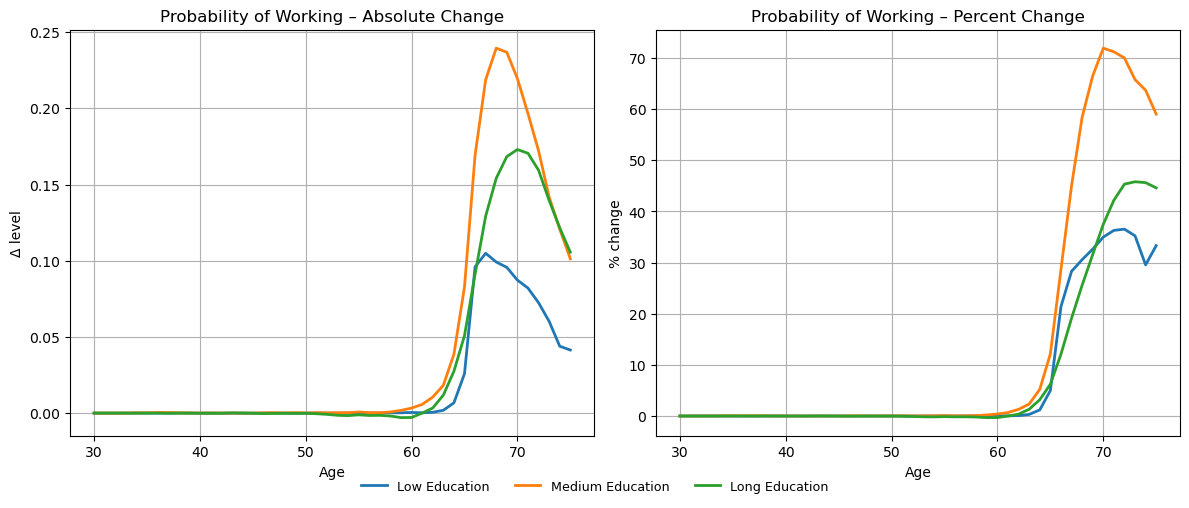

In [86]:
metric_labels = {
    "avg_hours":       "Average Hours",
    "avg_wealth":      "Average Wealth",
    "avg_consumption": "Average Consumption",
    "prob_work":       "Probability of Working"
}
edu_labels = {
    "edu1": "Low Education",
    "edu2": "Medium Education",
    "edu3": "Long Education"
}

plot_metrics_individual(
    df_diff_all,
    metrics,
    edu_labels=edu_labels,
    metric_labels=metric_labels,
    figsize=(12, 5),
    legend_y_offset=-0.02,
)

